In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import xarray_extras.csv as csv
import cmcrameri 
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.colors import Normalize, CenteredNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
! squeue

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          23202385    single jupyterh   vt0186  R       3:21      1 uc2n296
          23202390    single  run_euq   vt0186  R       0:07      1 uc2n545


In [6]:
idx = {"u10":0, "v10":1, "t2m":2, "t850":3, "z500":4, "tp":5}
results_path = "../results/fcn/"
plot_path = "../plots/fcn/"

In [7]:
# Open dataset
baselines = xr.open_dataset(results_path + "crps_metrics.h5").rename({"phony_dim_0" : "ics", "phony_dim_1" : "var", "phony_dim_4": "lead_time", "phony_dim_2": "lat", "phony_dim_3": "lon"})
eq = xr.open_dataset(results_path + "eq_crps.h5").rename({"phony_dim_0" : "ics", "phony_dim_1" : "lead_time", "phony_dim_2": "var", "phony_dim_3": "lat", "phony_dim_4": "lon"})
ecmwf = xr.open_dataset(results_path + "ecmwf_crps.h5").rename({"phony_dim_0" : "ics", "phony_dim_1" : "lead_time", "phony_dim_2": "var", "phony_dim_3": "lat", "phony_dim_4": "lon"})
eq_median = xr.open_dataset(results_path + "eq_median.h5").rename({"phony_dim_0" : "ics", "phony_dim_1" : "lead_time", "phony_dim_2": "var", "phony_dim_3": "lat", "phony_dim_4": "lon"})
lm = xr.open_dataset(results_path + "lm_crps.h5").rename({"phony_dim_0" : "ics", "phony_dim_1" : "lead_time", "phony_dim_2": "var", "phony_dim_3": "lat", "phony_dim_4": "lon"})
drn = xr.open_dataset(results_path + "drn_crps.h5").rename({"phony_dim_0" : "ics", "phony_dim_1" : "lead_time", "phony_dim_2": "var", "phony_dim_3": "lat", "phony_dim_4": "lon"})

In [8]:
ens_fc = baselines.ens_fc
easyuq = eq.eq
ecmwf_fcn = ecmwf.fcn_ics
ecmwf_ics = ecmwf.ics
ens_lm = lm.ics
drn_single = drn.drn_single

In [9]:
# Plot parameters
plt.style.use('seaborn-v0_8-whitegrid')
cmap_name = "cmc.roma_r"
cmap = plt.get_cmap(cmap_name)
plt.rcParams['image.cmap'] = cmap_name

cmap_error = "cmc.vik"

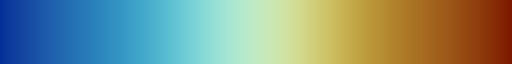

In [10]:
cmap

In [16]:
# Sizes
lw = 4.2
titlesize = 35
ticksize = 25
axissize = 30

In [17]:
# ECMWF Europe grid 
# 35-75°N und von 12.5°W bis 42.5°E
lon = [-12.5, 42.5]
lat = [35,75]
lons = np.arange(lon[0], lon[1], 0.25)
lats = np.flip(np.arange(lat[0], lat[1], 0.25))
lead_times = [4,12,28]

In [18]:
methods = ["ECMWF IFS", "GNP", "IFSP", "RFP", "EasyUQ", "DRN"]

In [22]:
colors = {"ECMWF IFS": "black", "GNP": cmap(0.01), "IFSP": cmap(0.25), "RFP": cmap(0.38), "EasyUQ": cmap(0.65), "DRN": cmap(0.85)}

# Aggregated results

In [ ]:
iterables = [["Short","Mid", "Long"],["u10", "v10", "t2m", "t850", "z500"]]
col_names = ["Gaussian", "ECMWF ICS", "ECMWF IFS", "RF", "EasyUQ", "DRN"]
methods = [ecmwf_fcn, ecmwf_ics, ens_lm, easyuq, drn_single]

index = pd.MultiIndex.from_product(iterables, names=["Lead time", "variables"])

data = pd.DataFrame(np.zeros((15,6)), index=index, columns = col_names)

for var in list(idx.keys())[0:5]:
    # FCN
    data.loc[("Short", var), "Gaussian"] = ens_fc.isel(phony_dim_1 = idx[var], phony_dim_4 = slice(1,9)).mean()
    data.loc[("Mid", var), "Gaussian"] = ens_fc.isel(phony_dim_1 = idx[var], phony_dim_4 = slice(9,21)).mean()
    data.loc[("Long", var), "Gaussian"] = ens_fc.isel(phony_dim_1 = idx[var], phony_dim_4 = slice(21,32)).mean()

    #Other methods
    for x, method in enumerate(methods):
        data.loc[("Short", var), col_names[x+1]] = method.isel(phony_dim_2 = idx[var], phony_dim_1 = slice(1,9)).mean()
        data.loc[("Mid", var), col_names[x+1]] = method.isel(phony_dim_2 = idx[var], phony_dim_1 = slice(9,21)).mean()
        data.loc[("Long", var), col_names[x+1]] = method.isel(phony_dim_2 = idx[var], phony_dim_1 = slice(21,32)).mean()     

# Per time

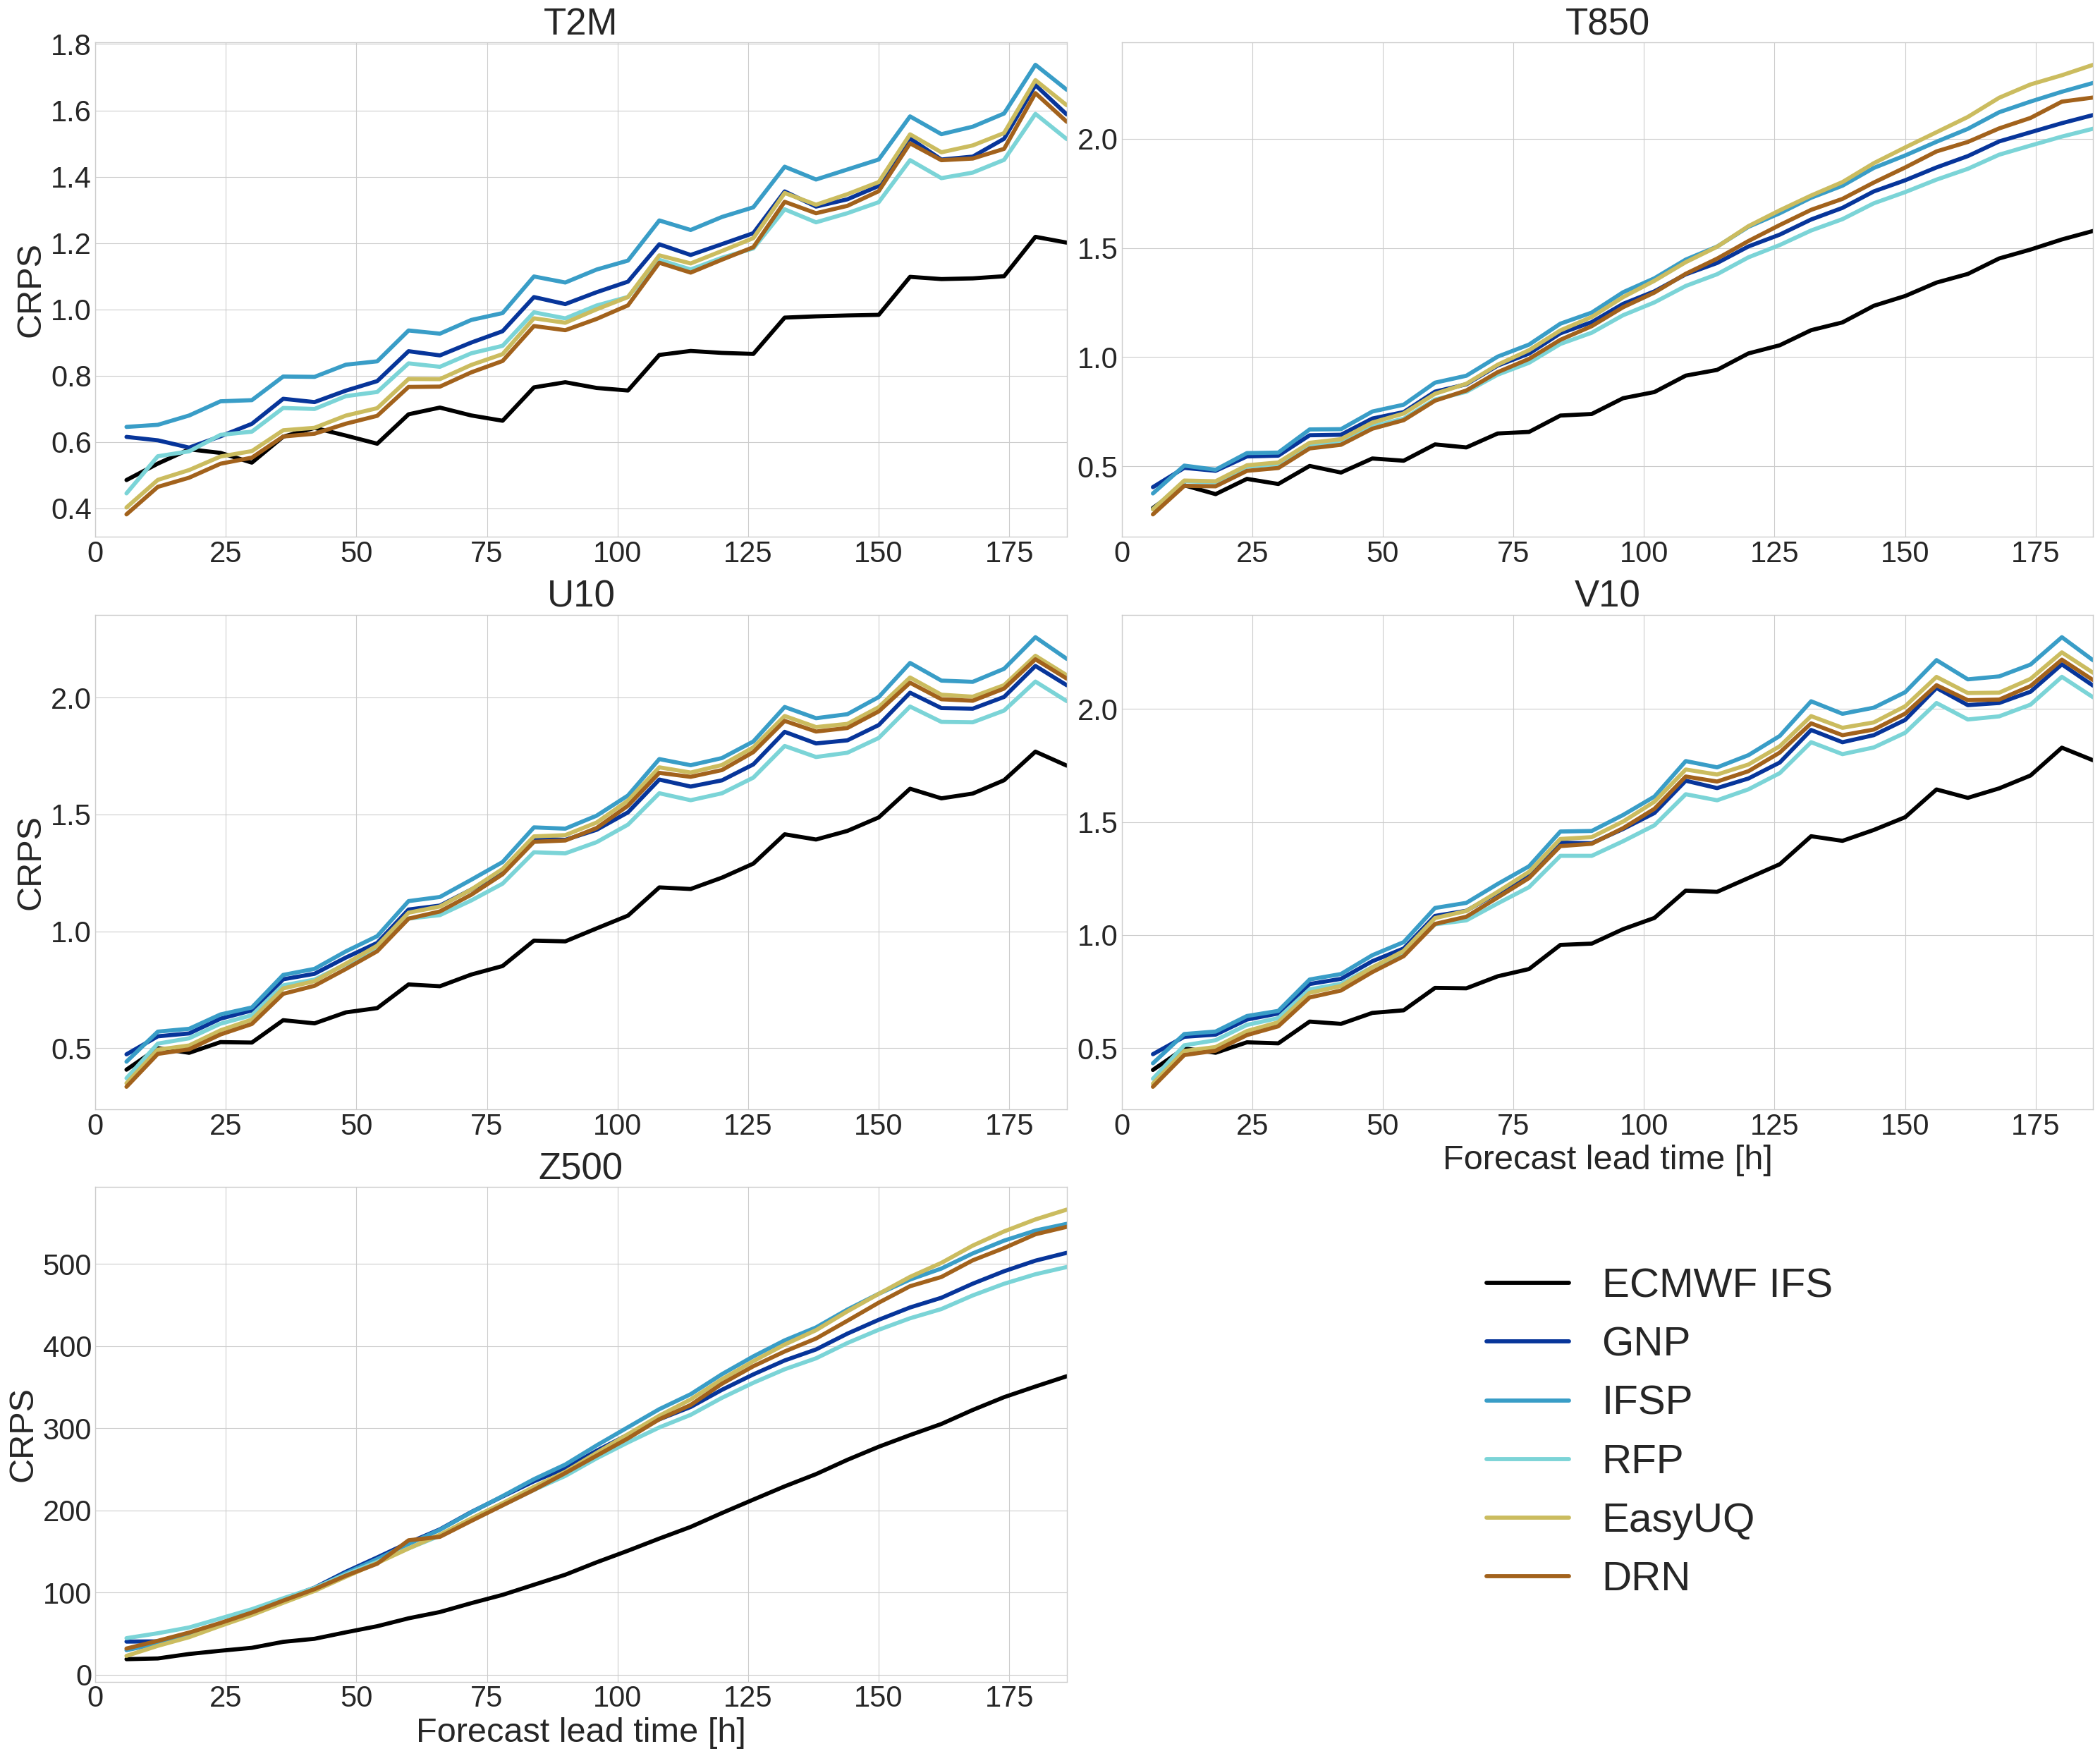

In [23]:
fig, axs = plt.subplots(3, 2, figsize = (30,25))
axs = axs.ravel()
hour_range = np.arange(1, ens_fc.shape[1])*6
marker = " "

for i, var in enumerate([2,3,0,1,4]):
    axs[i].plot(hour_range, ecmwf_ics.isel(var = var, lead_time = slice(1,32)).mean(dim = ["ics", "lat", "lon"]), marker = marker, color = colors["ECMWF IFS"], lw = lw)
    axs[i].plot(hour_range, ens_fc.isel(var = var, lead_time = slice(1,32)).mean(dim = ["ics", "lat", "lon"]), marker = marker, color = colors["GNP"], lw = lw)
    axs[i].plot(hour_range, ecmwf_fcn.isel(var = var, lead_time = slice(1,32)).mean(dim = ["ics", "lat", "lon"]), marker = marker, color = colors["IFSP"], lw =lw)
    axs[i].plot(hour_range, ens_lm.isel(var = var, lead_time = slice(1,32)).mean(dim = ["ics", "lat", "lon"]), marker = marker, color = colors["RFP"], lw = lw)    
    axs[i].plot(hour_range, easyuq.isel(var = var, lead_time = slice(1,32)).mean(dim = ["ics", "lat", "lon"]), marker = marker, color = colors["EasyUQ"], lw = lw)           
    axs[i].plot(hour_range, drn_single.isel(var = var, lead_time = slice(1,32)).mean(dim = ["ics", "lat", "lon"]), marker = marker, color = colors["DRN"], lw = lw)

    axs[i].set_title(f"{list(idx.keys())[var]}".upper(), fontsize = titlesize+3)
    axs[i].set_xlim([0, 186])
    axs[i].tick_params(axis='both', labelsize = ticksize+5)
    
axs[3].set_xlabel("Forecast lead time [h]", fontsize = axissize+5)
axs[4].set_xlabel("Forecast lead time [h]", fontsize = axissize+5)
axs[0].set_ylabel("CRPS", fontsize = axissize+5)
axs[2].set_ylabel("CRPS", fontsize = axissize+5)
axs[4].set_ylabel("CRPS", fontsize = axissize+5)

#Remove unused axis
axs[5].remove()
    
fig.legend(loc=(0.7,0.08), labels = methods, fontsize = titlesize+7)
    
fig.tight_layout()
plt.savefig(plot_path + f"cprs_per_time.pdf", bbox_inches = "tight", dpi = 300)

# Per gridpoint (CRPSS)

In [ ]:
fig, axs = plt.subplots(3,5, figsize = (28,10),subplot_kw={'projection': ccrs.PlateCarree()})
var = 4

for ax in axs.ravel():
    ax.set_extent([lon[0], lon[1]-0.25, lat[0], lat[1]], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)

normalizer=CenteredNorm(halfrange = 1) # 0,1
#normalizer=Normalize(-0.5,0.6) # 2
#normalizer=Normalize(-0.2,0.3) # 3
#normalizer=Normalize(-0.2,0.25) # 4
im=cm.ScalarMappable(norm=normalizer, cmap = cmap_error)

for t, lead_time in enumerate(lead_times):    
    ref = ecmwf_ics.isel(var = var, lead_time = lead_time).mean(dim = ["ics"])
    
    axs[t,0].contourf(lons, lats, (ref.data-ens_fc.isel(var = var, lead_time = lead_time).mean(dim = ["ics"]))/ref.data, 60, transform=ccrs.PlateCarree(), norm = normalizer, cmap = cmap_error)
    axs[t,1].contourf(lons, lats, (ref.data-ecmwf_fcn.isel(var = var, lead_time = lead_time).mean(dim = ["ics"]))/ref.data, 60, transform=ccrs.PlateCarree(), norm = normalizer, cmap = cmap_error)
    axs[t,2].contourf(lons, lats, (ref.data-ens_lm.isel(var = var, lead_time = lead_time).mean(dim = ["ics"]))/ref.data, 60, transform=ccrs.PlateCarree(), norm = normalizer, cmap = cmap_error)
    axs[t,3].contourf(lons, lats, (ref.data-easyuq.isel(var = var, lead_time = lead_time).mean(dim = ["ics"]))/ref.data, 60, transform=ccrs.PlateCarree(), norm = normalizer, cmap = cmap_error)
    axs[t,4].contourf(lons, lats, (ref.data-drn_single.isel(var = var, lead_time = lead_time).mean(dim = ["ics"]))/ref.data, 60, transform=ccrs.PlateCarree(), norm = normalizer, cmap = cmap_error)
    
    # Lead time
    axs[t,0].set_xticks([])
    axs[t,0].set_yticks([])
    axs[t,0].set_ylabel(f"Lead time: {lead_time *6}h", fontsize = axissize)

# Set title
axs[0,0].set_title("GNP", fontsize = axissize)
axs[0,1].set_title("IFSP", fontsize = axissize)
axs[0,2].set_title("RFP", fontsize = axissize)
axs[0,3].set_title("EasyUQ", fontsize = axissize)
axs[0,4].set_title("DRN", fontsize = axissize)

# Remove all axis label
axs = axs.ravel()
for i in range(len(axs)):
    if i%5!=0:
        axs[i].set_ylabel(None)
    axs[i].set_xlabel(None)

plt.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.805, 0.05, 0.05, 0.86])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.tick_params(labelsize=ticksize)

#plt.suptitle(f"CRPSS against Gaussian model for variable {list(idx.keys())[var]}", fontsize = titlesize)

plt.savefig(plot_path + f"crpss_per_grid_{list(idx.keys())[var]}.png", bbox_inches = "tight")

In [ ]:
%%capture

for var in range(5):
    fig, axs = plt.subplots(3,5, figsize = (28,10),subplot_kw={'projection': ccrs.PlateCarree()})
    for ax in axs.ravel():
        ax.set_extent([lon[0], lon[1]-0.25, lat[0], lat[1]], crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE)
        

    normalizer=CenteredNorm(halfrange = 1)
    im=cm.ScalarMappable(norm=normalizer, cmap = cmap_error)

    for t, lead_time in enumerate(lead_times):    
        ref = ecmwf_ics.isel(var = var, lead_time = lead_time).mean(dim = ["ics"])
        
        axs[t,0].contourf(lons, lats, (ref.data-ens_fc.isel(var = var, lead_time = lead_time).mean(dim = ["ics"]))/ref.data, 60, transform=ccrs.PlateCarree(), norm = normalizer, cmap = cmap_error)
        axs[t,1].contourf(lons, lats, (ref.data-ecmwf_fcn.isel(var = var, lead_time = lead_time).mean(dim = ["ics"]))/ref.data, 60, transform=ccrs.PlateCarree(), norm = normalizer, cmap = cmap_error)
        axs[t,2].contourf(lons, lats, (ref.data-ens_lm.isel(var = var, lead_time = lead_time).mean(dim = ["ics"]))/ref.data, 60, transform=ccrs.PlateCarree(), norm = normalizer, cmap = cmap_error)
        axs[t,3].contourf(lons, lats, (ref.data-easyuq.isel(var = var, lead_time = lead_time).mean(dim = ["ics"]))/ref.data, 60, transform=ccrs.PlateCarree(), norm = normalizer, cmap = cmap_error)
        axs[t,4].contourf(lons, lats, (ref.data-drn_single.isel(var = var, lead_time = lead_time).mean(dim = ["ics"]))/ref.data, 60, transform=ccrs.PlateCarree(), norm = normalizer, cmap = cmap_error)
        
        # Lead time
        axs[t,0].set_xticks([])
        axs[t,0].set_yticks([])
        axs[t,0].set_ylabel(f"Lead time: {lead_time *6}h", fontsize = axissize)

    # Set title
    axs[0,0].set_title("GNP", fontsize = axissize)
    axs[0,1].set_title("IFSP", fontsize = axissize)
    axs[0,2].set_title("RFP", fontsize = axissize)
    axs[0,3].set_title("EasyUQ", fontsize = axissize)
    axs[0,4].set_title("DRN", fontsize = axissize)
    
    # Remove all axis label
    axs = axs.ravel()
    for i in range(len(axs)):
        if i%5!=0:
            axs[i].set_ylabel(None)
        axs[i].set_xlabel(None)

    plt.tight_layout()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.805, 0.05, 0.05, 0.86])
    cb = fig.colorbar(im, cax=cbar_ax)
    cb.ax.tick_params(labelsize=ticksize)

    #plt.suptitle(f"CRPSS against Gaussian model for variable {list(idx.keys())[var]}", fontsize = titlesize)
    plt.savefig(plot_path + f"crpss_per_grid_{list(idx.keys())[var]}.png", bbox_inches = "tight")

# PIT Histogram

In [29]:
n_grid = 10
var = 4

In [30]:
pit = np.load(results_path + f"pit_{list(idx.keys())[var]}.npy").reshape(-1,3,6)

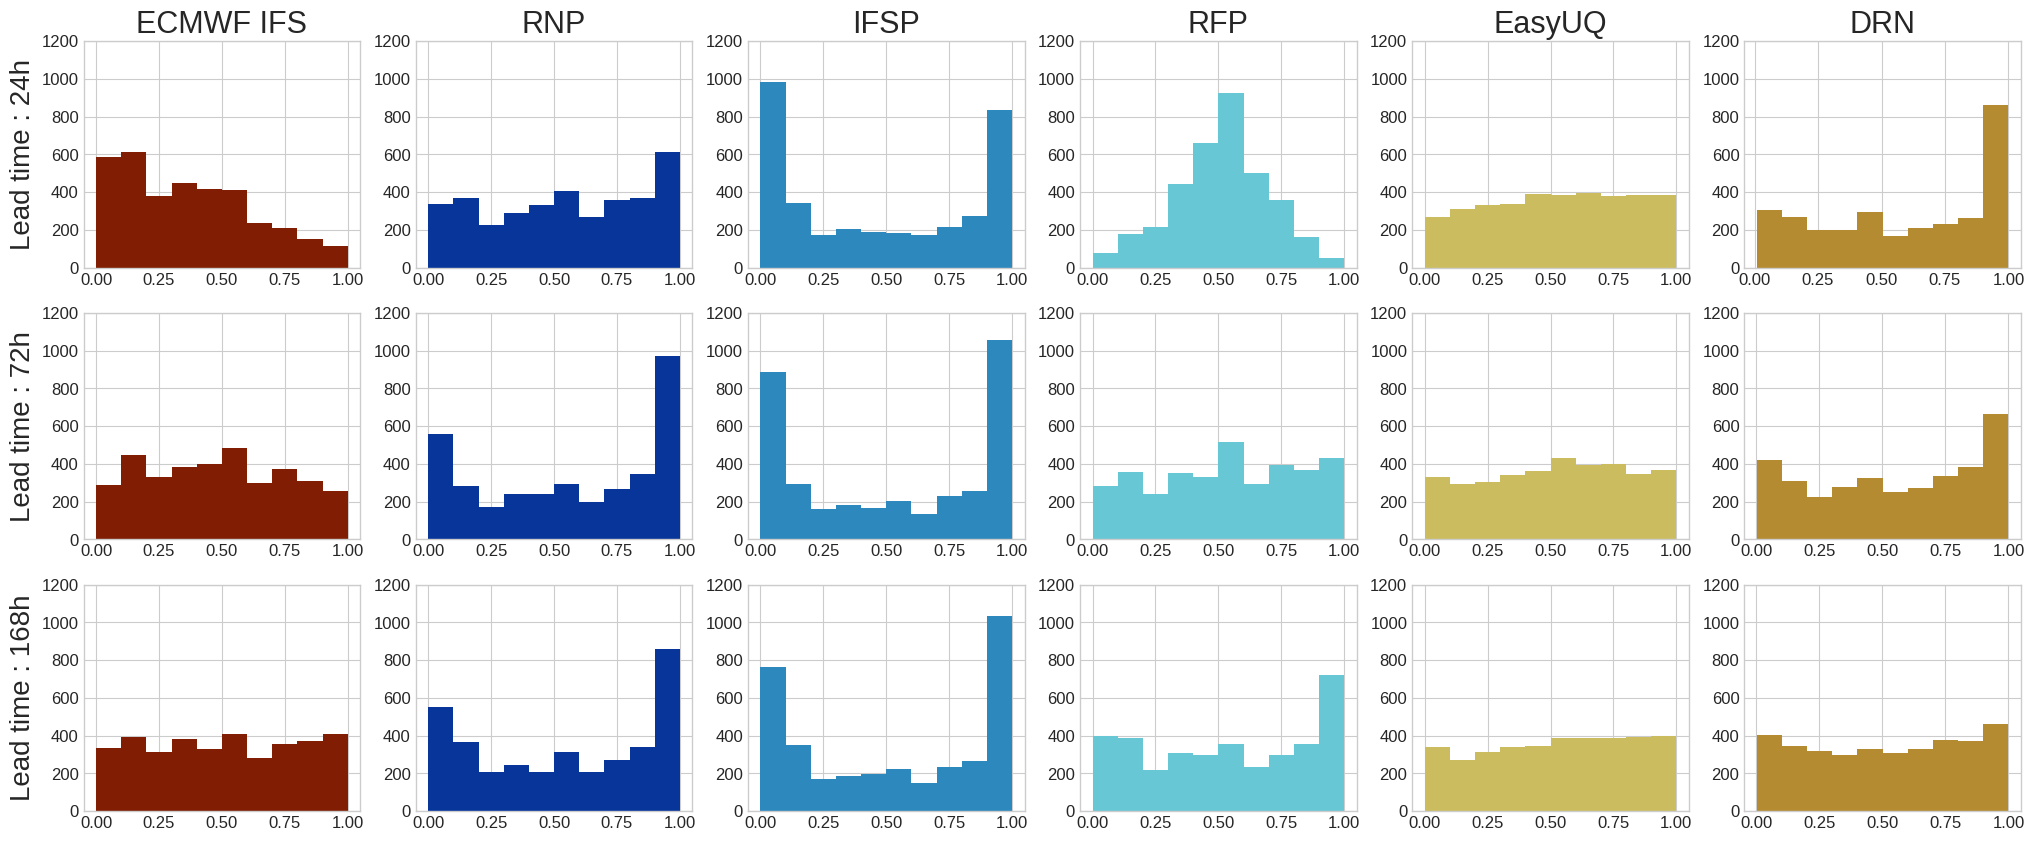

In [32]:
models = ["ECMWF IFS", "GNP", "IFSP", "RFP", "EasyUQ", "DRN"]
cols = list(colors.values())

fig, axs = plt.subplots(3, 6, figsize = (25,10))


for i, model in enumerate(models):
    for t, lead_time in enumerate(lead_times):
        axs[t,i].hist(pit[:,t,i], color = cols[i])
        axs[t,i].set_ylim([0,1200])
        axs[t,0].set_ylabel(f"Lead time : {6*lead_time}h", fontsize = 20)
        axs[t,i].tick_params(axis='both', labelsize = 12)
        
    axs[0,i].set_title(f"{model}", fontsize = 22)
        
#fig.suptitle(f'PIT histograms for variable {list(idx.keys())[var]} and {n_grid} random grid points', fontsize = 25)

plt.savefig(plot_path + f"pit_{list(idx.keys())[var]}.pdf", bbox_inches = "tight")

# Bias

In [ ]:
var = 4
bias_results = np.load(results_path+f"bias_results_{list(idx.keys())[var]}.npy")

In [ ]:
fig, axs = plt.subplots(3,4, figsize = (22,10),subplot_kw={'projection': ccrs.PlateCarree()})

for ax in axs.ravel():
    ax.set_extent([lon[0], lon[1]-1, lat[0], lat[1]], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    
# Normalizer
normalizer=Normalize(bias_results.min(),bias_results.max())
im=cm.ScalarMappable(norm=normalizer, cmap = "cmc.vik")
    
for t, lead_time in enumerate(lead_times):
    for i in range(4):
        axs[t,i].contourf(lons, lats, bias_results[i,t], 60, transform=ccrs.PlateCarree(), norm = normalizer, cmap = "cmc.vik")
        
    axs[t,0].set_xticks([])
    axs[t,0].set_yticks([])
    axs[t,0].set_ylabel(f"Lead time: {lead_time *6}h", fontsize = axissize)
axs[0,0].set_title("GP", fontsize = axissize)
axs[0,1].set_title("RFP", fontsize = axissize)
axs[0,2].set_title("IFSP", fontsize = axissize)
axs[0,3].set_title("DRN", fontsize = axissize)

plt.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.805, 0.05, 0.05, 0.86])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.tick_params(labelsize=ticksize)

#plt.suptitle(f"Bias for variable {list(idx.keys())[var]}", fontsize = titlesize)
plt.savefig(plot_path+f"bias_{list(idx.keys())[var]}.png", bbox_inches = "tight")

# RMSE spread

In [ ]:
var = 4
models = ["GP", "IFSP", "RFP", "ECMWF IFS"]
colors = [cmap(0.15), cmap(0.4), cmap(0.65), cmap(0.01)]
results = np.load(results_path + f"rmse_spread_{list(idx.keys())[var]}.npy")

In [ ]:
fig, axs = plt.subplots(figsize = (10,12))
h = np.arange(1,32)*6

for i in range(4):
    axs.plot(h,results[i, 0,1:32].mean(axis = 1), color = colors[i], lw = lw, label = models[i])
    axs.plot(h,results[i, 1,1:32].mean(axis = 1), color = colors[i], linestyle = "--", lw = lw)

axs.legend(fontsize = axissize)
axs.set_ylabel(f"RMSE", fontsize = axissize)
axs.set_xlabel(f"Time [h]", fontsize = axissize)
axs.tick_params(axis='both', labelsize = ticksize)
axs.set_xlim([6,186])

#fig.suptitle(list(idx.keys())[var], fontsize = titlesize)
plt.savefig(plot_path + f"rmse_spread_{list(idx.keys())[var]}.pdf")

# Workflow graphic

In [ ]:
cmap = plt.get_cmap('viridis', 15) 
cmap

In [ ]:
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF

n = 150
sample = np.random.normal(loc=0.0, scale=1.0, size=n)
x = np.linspace(-3,3,n)
cdf = norm().pdf(x)
ecdf = ECDF(sample)


In [ ]:
lw = 10
fig, axs = plt.subplots(figsize = (20,10))

axs.scatter(sample, np.zeros(n), marker = ".", color = "black", s = 50)
axs.plot(x, cdf,color = cmap(0.7), lw = lw)


plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.axis('off')
plt.savefig(f"workflow_drn.png", bbox_inches='tight', pad_inches = 0)

In [ ]:
#plt.style.use("seaborn-v0_8")

fig, axs = plt.subplots(figsize = (20,10))

axs.scatter(sample, np.zeros(n), marker = ".", color = "black", s = 50)
axs.plot(ecdf.x, ecdf.y, color = cmap(0.4), lw = lw)


plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.axis('off')
plt.savefig(f"workflow_eq.png", bbox_inches='tight', pad_inches = 0)

In [ ]:
#plt.style.use("seaborn-v0_8")

fig, axs = plt.subplots(figsize = (20,10))


axs.hist(sample, density=True, histtype='bar', color=cmap(0.2))


#axs.scatter(sample, np.zeros(n), marker = ".", color = "black", s = 50)

#axs.vlines([0,0.4,0.7, 0.45], 0, 1, color = [cmap(0.1), cmap(0.3), cmap(0.6), cmap(0.8)], linestyles = "dashed", alpha = 0.7,  lw = lw)

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.axis('off')
plt.savefig(f"workflow_hist.png", bbox_inches='tight', pad_inches = 0)

## RF

In [ ]:
dat_2019 = xr.open_dataset("../../../data/out_of_sample/2019.h5").fields.isel(phony_dim_0 = 1200, phony_dim_1 = 0) 
dat_2020 = xr.open_dataset("../../../data/out_of_sample/2020.h5").fields.isel(phony_dim_0 = 1240, phony_dim_1 = 0) 
diff = (dat_2020- dat_2019)

cmap = plt.get_cmap('viridis') 

In [ ]:
fig, axs = plt.subplots(figsize = (25,14))
dat_2019.plot(cmap = cmap, yincrease = False, add_colorbar = False)

plt.axis('off')
plt.savefig(f"workflow_rf_1.png", bbox_inches='tight', pad_inches = 0)

In [ ]:
fig, axs = plt.subplots(figsize = (25,14))
dat_2020.plot(cmap = cmap, yincrease = False, add_colorbar = False)

plt.axis('off')
plt.savefig(f"workflow_rf_2.png", bbox_inches='tight', pad_inches = 0)

In [ ]:
fig, axs = plt.subplots(figsize = (25,14))
diff.plot(cmap = cmap, yincrease = False, add_colorbar = False)

plt.axis('off')
plt.savefig(f"workflow_rf_diff.png", bbox_inches='tight', pad_inches = 0)

In [ ]:
fig, axs = plt.subplots(figsize = (25,14))
randn = np.random.normal(size = (140,288))

plt.pcolormesh(randn, cmap = "binary")

plt.axis('off')
plt.savefig(f"workflow_noise.png", bbox_inches='tight', pad_inches = 0)